# Stage 2 - Lesson 5: Retraining with New Data

In this notebook, we'll learn how to:
1. Load our existing model from MLflow
2. Simulate new data arriving over time
3. Evaluate if retraining is needed
4. Retrain the model when performance drops
5. Register and version our models

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# MLflow
import mlflow
import mlflow.xgboost
from mlflow.tracking import MlflowClient

# Set random seed for reproducibility
np.random.seed(42)

## 1. Connect to MLflow and load our best model

In [2]:
# Set MLflow tracking URI - this should match what you set up in Lesson 1
mlflow.set_tracking_uri("http://localhost:5000")

# Set the experiment
experiment_name = "google_stock_prediction"
mlflow.set_experiment(experiment_name)

# Get the experiment ID
experiment = mlflow.get_experiment_by_name(experiment_name)
experiment_id = experiment.experiment_id
print(f"Working with experiment '{experiment_name}' (ID: {experiment_id})")

Working with experiment 'google_stock_prediction' (ID: 254540670382524557)


In [3]:
# Function to find our best model from previous runs
def find_best_model(experiment_id, metric="test_rmse", mode="min"):
    """Find the best model based on a metric"""
    client = MlflowClient()
    
    # Search for runs with models
    runs = client.search_runs(
        experiment_ids=[experiment_id],
        filter_string="tags.mlflow.runName LIKE '%xgboost%'"
    )
    
    if not runs:
        print("No model runs found!")
        return None
    
    # Find best run based on metric
    if mode == "min":
        best_run = min(runs, key=lambda run: run.data.metrics.get(metric, float('inf')))
    else:
        best_run = max(runs, key=lambda run: run.data.metrics.get(metric, float('-inf')))
    
    run_id = best_run.info.run_id
    metric_value = best_run.data.metrics.get(metric)
    print(f"Best model found: Run ID {run_id}")
    print(f"Best {metric}: {metric_value:.4f}")
    
    return run_id

# Find our best model
best_run_id = find_best_model(experiment_id, metric="test_rmse", mode="min")

if best_run_id:
    # Load the best model
    model_uri = f"runs:/{best_run_id}/xgboost_model"
    current_model = mlflow.xgboost.load_model(model_uri)
    print(f"Successfully loaded model from run: {best_run_id}")

Best model found: Run ID 243f356629e74bfebdd65d00961d2c65
Best test_rmse: 22.5710
Successfully loaded model from run: 243f356629e74bfebdd65d00961d2c65


## 2. Load our historical and future data

In a real-world scenario, new data arrives regularly. We'll simulate this by using our future data split from Lesson 1.

In [4]:
# Load the historical and future data
historical_data = pd.read_csv('../../data/mlops_stages/historical_features.csv')
future_data = pd.read_csv('../../data/mlops_stages/future_features.csv')

# Convert date columns to datetime
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
future_data['Date'] = pd.to_datetime(future_data['Date'])

print(f"Historical data: {historical_data.shape[0]} records from {historical_data['Date'].min()} to {historical_data['Date'].max()}")
print(f"Future data: {future_data.shape[0]} records from {future_data['Date'].min()} to {future_data['Date'].max()}")

Historical data: 802 records from 2021-06-16 00:00:00+00:00 to 2024-08-22 00:00:00+00:00
Future data: 90 records from 2024-08-23 00:00:00+00:00 to 2024-12-31 00:00:00+00:00


## 3. Simulate data arriving in weekly batches

In [5]:
def split_future_data_into_batches(future_data, batch_size_days=7):
    """Split future data into weekly batches to simulate new data arriving"""
    # Sort by date
    future_data = future_data.sort_values('Date')
    
    # Get the start date
    start_date = future_data['Date'].min()
    
    # Create batches
    batches = []
    current_date = start_date
    
    while current_date <= future_data['Date'].max():
        end_date = current_date + timedelta(days=batch_size_days)
        batch = future_data[
            (future_data['Date'] >= current_date) & 
            (future_data['Date'] < end_date)
        ].copy()
        
        if not batch.empty:
            batches.append(batch)
        
        current_date = end_date
    
    print(f"Split future data into {len(batches)} batches")
    return batches

# Split future data into weekly batches
data_batches = split_future_data_into_batches(future_data)

# Show info about the first few batches
for i, batch in enumerate(data_batches[:3]):
    print(f"Batch {i+1}: {len(batch)} records from {batch['Date'].min()} to {batch['Date'].max()}")

Split future data into 19 batches
Batch 1: 5 records from 2024-08-23 00:00:00+00:00 to 2024-08-29 00:00:00+00:00
Batch 2: 4 records from 2024-08-30 00:00:00+00:00 to 2024-09-05 00:00:00+00:00
Batch 3: 5 records from 2024-09-06 00:00:00+00:00 to 2024-09-12 00:00:00+00:00


## 4. Define functions for model evaluation and retraining

In [6]:
def prepare_features_target(df):
    """Prepare features and target from DataFrame"""
    # Define feature columns (exclude Date and target)
    feature_cols = [col for col in df.columns if col not in ['Date', 'target']]
    
    # Extract features and target
    X = df[feature_cols].values
    y = df['target'].values
    
    return X, y, feature_cols

def evaluate_model(model, data, threshold=20.0):
    """Evaluate model on new data and decide if retraining is needed"""
    X, y, _ = prepare_features_target(data)
    
    # Make predictions
    y_pred = model.predict(X)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    
    # Direction accuracy
    y_direction = np.diff(y) > 0
    y_pred_direction = np.diff(y_pred) > 0
    dir_acc = np.mean(y_direction == y_pred_direction) if len(y) > 1 else 0
    
    # Decide if retraining needed (if RMSE exceeds threshold)
    needs_retraining = rmse > threshold
    
    return {
        'rmse': rmse,
        'r2': r2,
        'direction_accuracy': dir_acc,
        'needs_retraining': needs_retraining
    }

def retrain_model(historical_data, new_data):
    """Retrain model with historical data + new data"""
    # Combine historical and new data
    combined_data = pd.concat([historical_data, new_data])
    combined_data = combined_data.sort_values('Date').reset_index(drop=True)
    
    # Prepare training data
    X_train, y_train, _ = prepare_features_target(combined_data)
    
    # Define model parameters (same as our original model)
    params = {
        'objective': 'reg:squarederror',
        'learning_rate': 0.1,
        'max_depth': 5,
        'n_estimators': 100,
        'subsample': 0.4,
        'colsample_bytree': 0.8,
        'seed': 42
    }
    
    # Train new model
    new_model = xgb.XGBRegressor(**params)
    new_model.fit(X_train, y_train)
    
    return new_model, combined_data

## 5. Simulate production deployment with retraining

In [7]:
def log_model_to_registry(model, data, metrics, version):
    """Log model to MLflow model registry"""
    with mlflow.start_run(run_name=f"retrained_model_v{version}") as run:
        # Log parameters
        mlflow.log_param("training_data_end_date", data['Date'].max())
        mlflow.log_param("data_size", len(data))
        mlflow.log_param("model_version", version)
        
        # Log metrics
        mlflow.log_metric("rmse", metrics['rmse'])
        mlflow.log_metric("r2", metrics['r2'])
        mlflow.log_metric("direction_accuracy", metrics['direction_accuracy'])
        
        # Set tags
        mlflow.set_tag("model_stage", "Production" if version > 1 else "Staging")
        mlflow.set_tag("retrained", "True")
        
        # Log model
        mlflow.xgboost.log_model(
            model, 
            f"google_stock_model_v{version}",
            registered_model_name="google_stock_forecaster",
            model_format="json"
        )
        
        run_id = run.info.run_id
        
    return run_id

In [8]:
# Start our simulation
current_model = current_model  # Our best model loaded earlier
current_data = historical_data.copy()
collected_data = []
model_version = 1

# Create a performance tracker
performance_tracker = []

# Register our initial model
initial_metrics = evaluate_model(current_model, current_data)
log_model_to_registry(current_model, current_data, initial_metrics, model_version)

# Simulate new data arriving in batches
for i, batch in enumerate(data_batches):
    week_num = i + 1
    print(f"\nWeek {week_num}: Processing data from {batch['Date'].min()} to {batch['Date'].max()}")
    
    # Collect new data
    collected_data.append(batch)
    new_data = pd.concat(collected_data)
    
    # Evaluate current model on new data
    metrics = evaluate_model(current_model, new_data)
    performance_tracker.append({
        'week': week_num,
        'date': batch['Date'].max(),
        'rmse': metrics['rmse'],
        'r2': metrics['r2'],
        'direction_accuracy': metrics['direction_accuracy'],
        'model_version': model_version
    })
    
    print(f"  Current model (v{model_version}) performance on new data:")
    print(f"  RMSE: ${metrics['rmse']:.2f}")
    print(f"  R²: {metrics['r2']:.4f}")
    print(f"  Direction Accuracy: {metrics['direction_accuracy']:.2%}")
    
    # Check if retraining is needed
    if metrics['needs_retraining'] and len(new_data) >= 20:  # Ensure we have enough new data
        print(f"  ⚠️ Model performance degraded! Retraining...")
        
        # Retrain the model
        model_version += 1
        current_model, current_data = retrain_model(current_data, new_data)
        
        # Evaluate new model
        new_metrics = evaluate_model(current_model, new_data)
        print(f"  New model (v{model_version}) performance:")
        print(f"  RMSE: ${new_metrics['rmse']:.2f}")
        print(f"  R²: {new_metrics['r2']:.4f}")
        print(f"  Direction Accuracy: {new_metrics['direction_accuracy']:.2%}")
        
        # Log the new model to MLflow
        run_id = log_model_to_registry(current_model, current_data, new_metrics, model_version)
        print(f"  Registered new model version {model_version} (Run ID: {run_id})")
        
        # Reset collected data after retraining
        collected_data = []
    else:
        print(f"  ✅ Model still performing well. No retraining needed.")
    
    # For demo purposes, don't process all batches
    if i >= 9:  # Process 10 weeks
        print("\nSimulation completed after 10 weeks.")
        break

2025/02/19 16:01:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'google_stock_forecaster' already exists. Creating a new version of this model...
2025/02/19 16:01:19 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: google_stock_forecaster, version 4
Created version '4' of model 'google_stock_forecaster'.


🏃 View run retrained_model_v1 at: http://localhost:5000/#/experiments/254540670382524557/runs/f5946b0850944474a0159bfcde75def6
🧪 View experiment at: http://localhost:5000/#/experiments/254540670382524557

Week 1: Processing data from 2024-08-23 00:00:00+00:00 to 2024-08-29 00:00:00+00:00
  Current model (v1) performance on new data:
  RMSE: $20.91
  R²: -157.7448
  Direction Accuracy: 0.00%
  ✅ Model still performing well. No retraining needed.

Week 2: Processing data from 2024-08-30 00:00:00+00:00 to 2024-09-05 00:00:00+00:00
  Current model (v1) performance on new data:
  RMSE: $18.52
  R²: -25.9320
  Direction Accuracy: 37.50%
  ✅ Model still performing well. No retraining needed.

Week 3: Processing data from 2024-09-06 00:00:00+00:00 to 2024-09-12 00:00:00+00:00
  Current model (v1) performance on new data:
  RMSE: $15.25
  R²: -5.2561
  Direction Accuracy: 38.46%
  ✅ Model still performing well. No retraining needed.

Week 4: Processing data from 2024-09-13 00:00:00+00:00 to 202

## 6. Visualize model performance over time

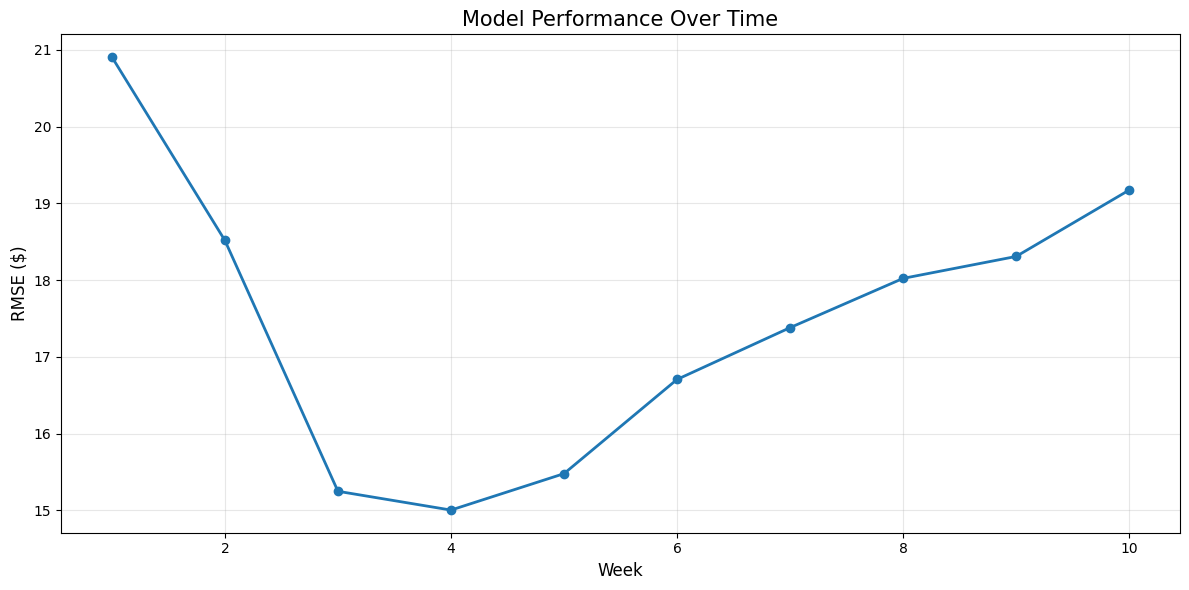

In [9]:
# Convert tracker to DataFrame
performance_df = pd.DataFrame(performance_tracker)

# Highlight when model versions changed
version_changes = performance_df['model_version'].diff().fillna(0) != 0

# Plot RMSE over time
plt.figure(figsize=(12, 6))
plt.plot(performance_df['week'], performance_df['rmse'], marker='o', linewidth=2)

# Add vertical lines when model was retrained
for i, changed in enumerate(version_changes):
    if changed and i > 0:
        plt.axvline(x=performance_df['week'][i], color='red', linestyle='--', alpha=0.7)
        plt.text(performance_df['week'][i]+0.1, plt.ylim()[1]*0.9, 
                 f"Model v{performance_df['model_version'][i]}", rotation=90)

plt.title('Model Performance Over Time', fontsize=15)
plt.xlabel('Week', fontsize=12)
plt.ylabel('RMSE ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Get model versions from MLflow Registry

In [10]:
# Get registered model versions
client = MlflowClient()
model_name = "google_stock_forecaster"

try:
    model_versions = client.search_model_versions(f"name='{model_name}'")
    
    if model_versions:
        print(f"Models in registry for '{model_name}':")
        for mv in model_versions:
            print(f"  Version: {mv.version}, Created: {datetime.fromtimestamp(mv.creation_timestamp/1000)}")
            print(f"  Run ID: {mv.run_id}")
            print(f"  Status: {mv.status}, Stage: {mv.current_stage}")
            print()
    else:
        print(f"No models found with name '{model_name}'")
except Exception as e:
    print(f"Error retrieving models: {e}")

Models in registry for 'google_stock_forecaster':
  Version: 4, Created: 2025-02-19 16:01:19.512000
  Run ID: f5946b0850944474a0159bfcde75def6
  Status: READY, Stage: None

  Version: 3, Created: 2025-02-19 15:59:29.737000
  Run ID: 4097a476dac24a94a4edcca6f4602a78
  Status: READY, Stage: None

  Version: 2, Created: 2025-02-19 15:59:02.099000
  Run ID: fc1803e26ec540fda2eb84a652e13c80
  Status: READY, Stage: None

  Version: 1, Created: 2025-02-19 15:55:03.213000
  Run ID: fbc00ce92a3542918f2e4b0b2f42fa21
  Status: READY, Stage: None



## 8. (Optional) Promote the best model to production

In a real-world scenario, you might want to manually review the model before promoting it to production.

In [11]:
# Find the model version with the lowest RMSE
# (In a real scenario, you would review multiple metrics and possibly perform A/B testing)
if len(performance_df) > 0:
    best_version = performance_df.loc[performance_df['rmse'].idxmin(), 'model_version']
    best_rmse = performance_df['rmse'].min()
    
    print(f"Best performing model: Version {best_version} with RMSE ${best_rmse:.2f}")
    
    # Uncomment to actually promote the model
    # try:
    #     client.transition_model_version_stage(
    #         name=model_name,
    #         version=int(best_version),
    #         stage="Production"
    #     )
    #     print(f"Promoted model version {best_version} to Production")
    # except Exception as e:
    #     print(f"Error promoting model: {e}")

Best performing model: Version 1 with RMSE $15.01


## 9. Summary: Key Concepts Learned

In this lesson, we've learned how to:

1. **Monitor model performance over time** - Tracking metrics like RMSE and directional accuracy  
2. **Set up retraining triggers** - Defining thresholds that indicate when to retrain  
3. **Automate the retraining process** - Creating a pipeline that retrains when needed  
4. **Manage model versions** - Using MLflow's model registry to track versions  
5. **Promote models to production** - Moving well-performing models to production  

These concepts form the foundation of a robust MLOps system that can maintain model performance as data changes over time.